# Experiment With Rommel's Data

This notebook performs some prior predictive checks for a mixed effects pharmacokinetic regression model.  The posterior for this model will then be summarized and used as a prior for future experiments.

In [4]:
%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az



from utils.regression_models import regression_model_factory
from utils.tools import  summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
model_data = pd.read_csv('data/apixiban_regression_data.csv')

yobs = model_data.Concentration_scaled.values
subject_ids = pd.Categorical(model_data.Subject).codes 
times = model_data.Time.values


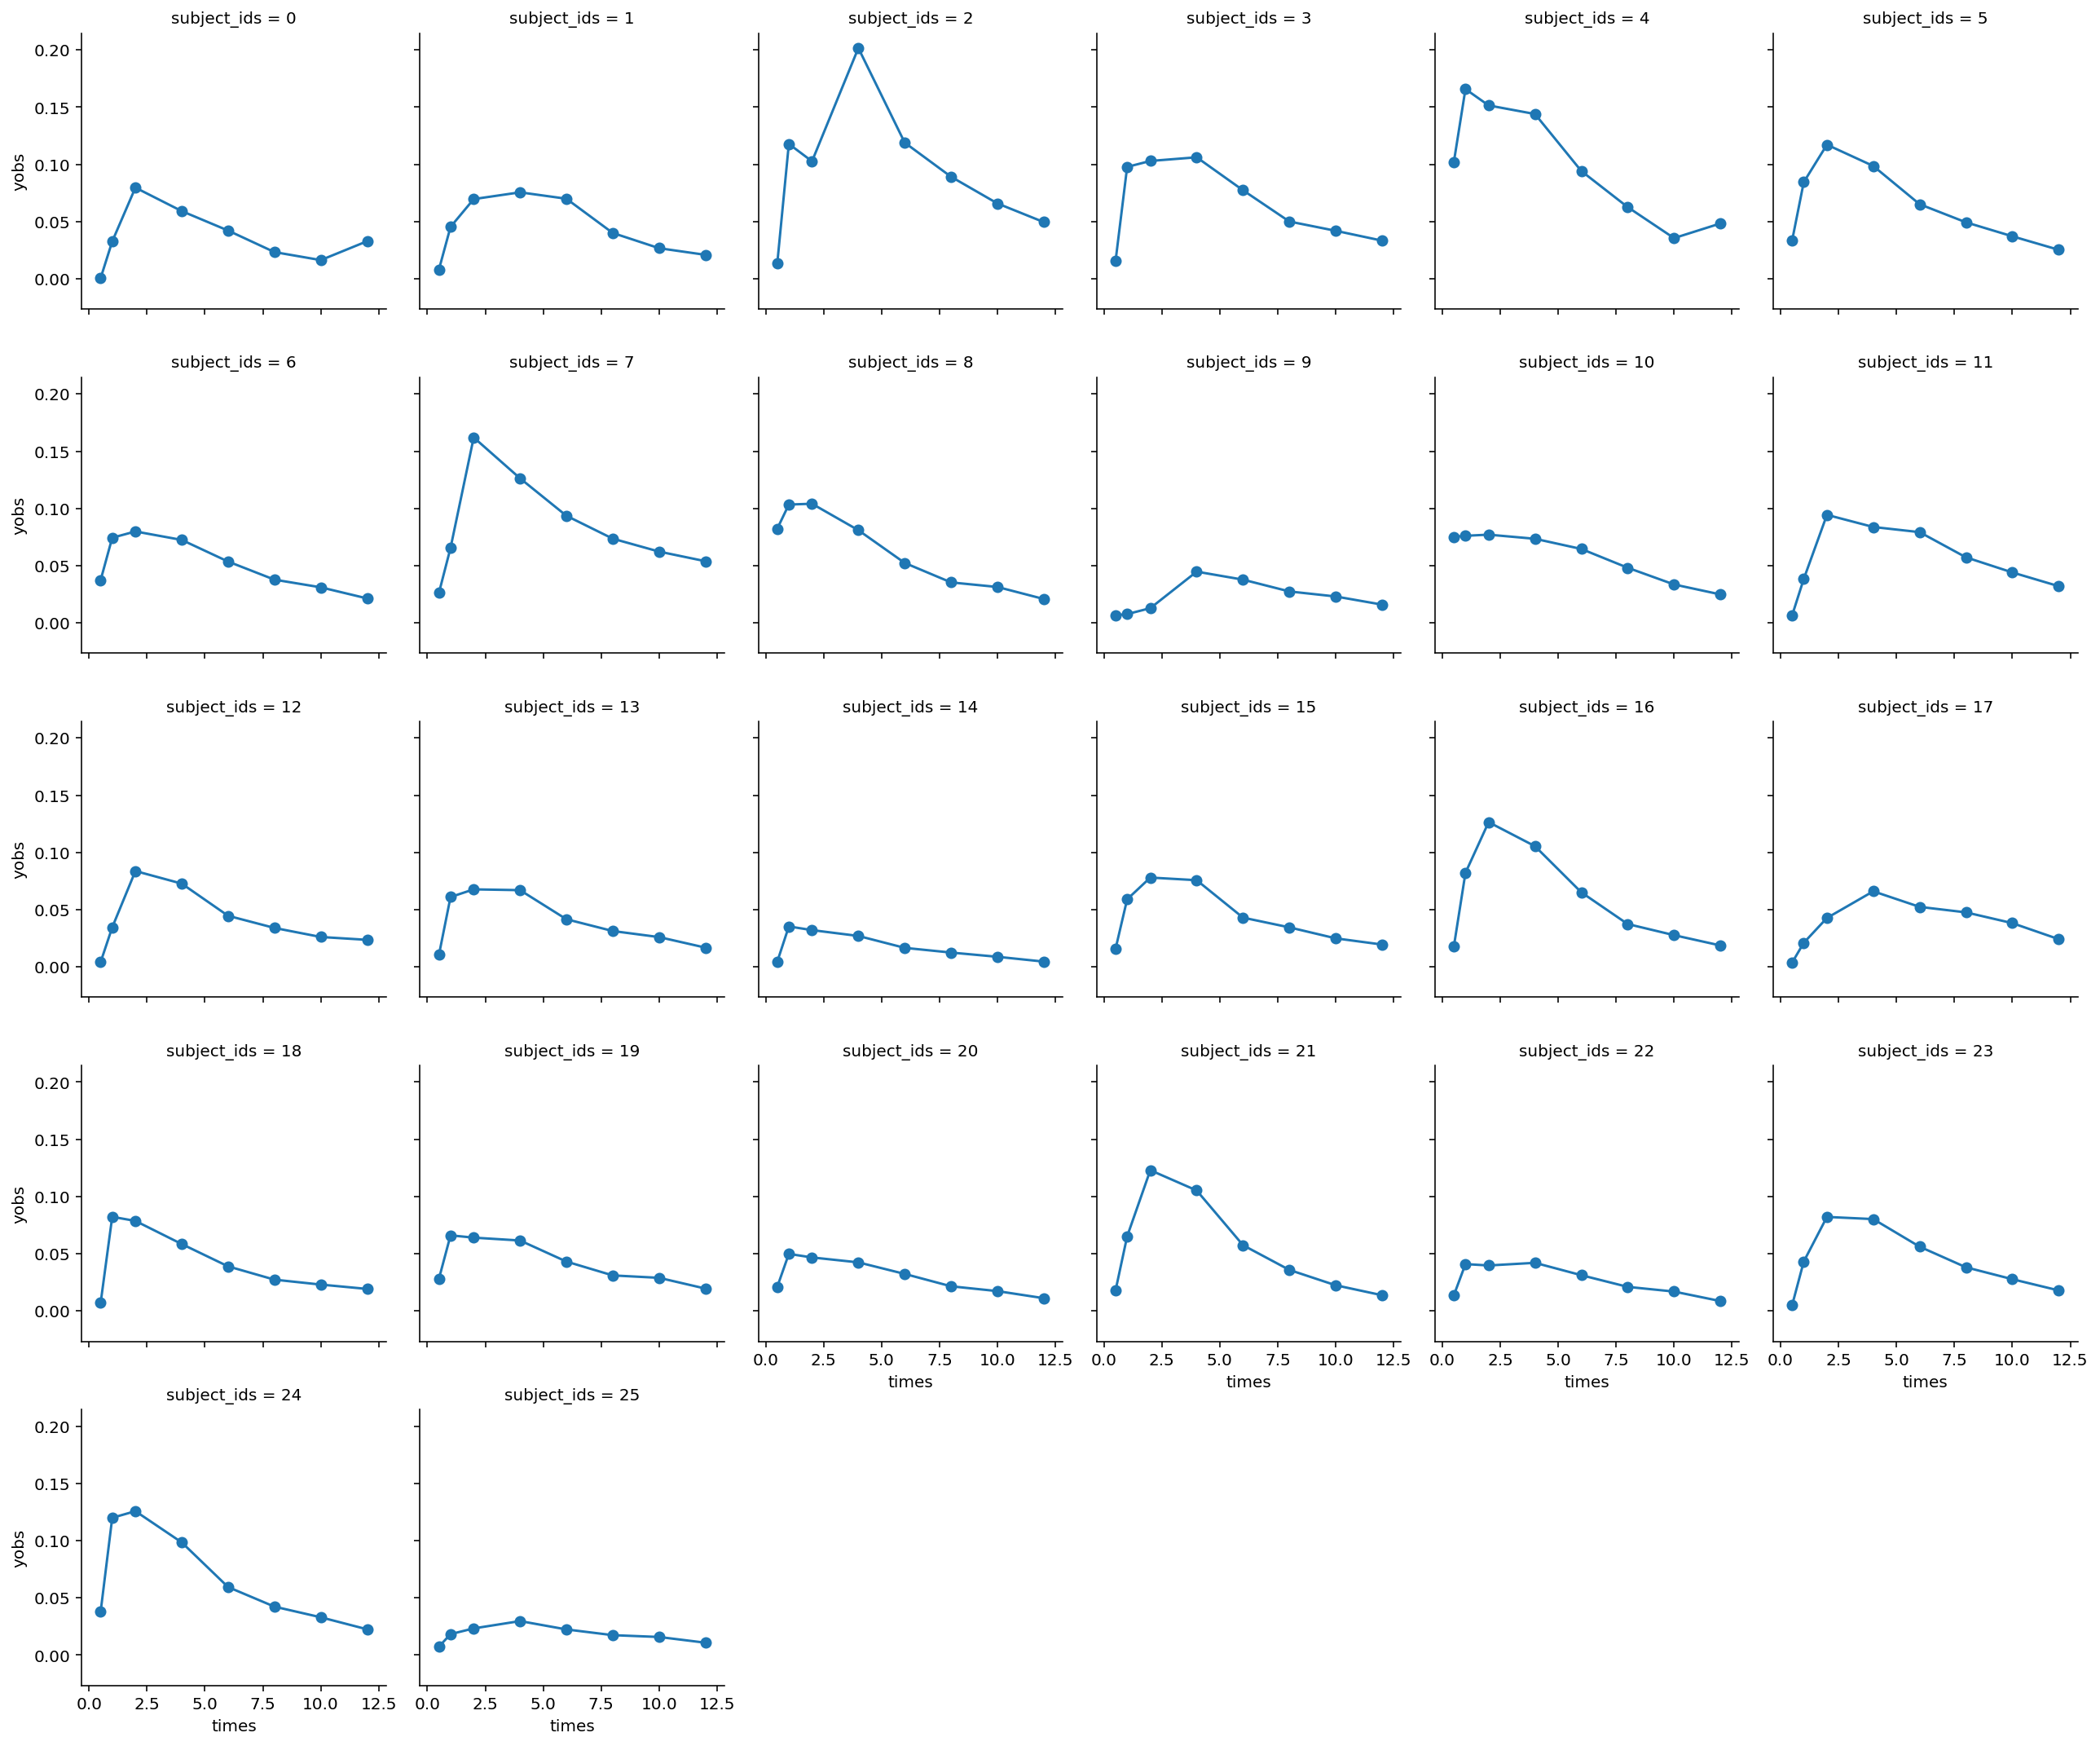

In [14]:
df = pd.DataFrame({'yobs':yobs,
                   'times':times,
                   'subject_ids':subject_ids})

g = sns.FacetGrid(data = df.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','yobs', color = 'C0')


# Regression Models

In [9]:
from sklearn.preprocessing import StandardScaler

covars = model_data.drop_duplicates("Subject").loc[:,['Sex', 'Creatinine', 'Age']]
covars['Sex'] = covars.Sex.apply(lambda x: 1 if x=='Male' else 0)


X = covars.values
X[:,1:] = StandardScaler().fit_transform(X[:,1:])

In [105]:
from utils.regression_models import regression_model_factory
with regression_model_factory(yobs, X, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    model = az.from_pymc3(prior = prior_predictive, trace = trace, posterior_predictive = posterior_predictive)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, betas_ka, alpha, s_ke, z_ke, betas_ke, log_ke, s_CL, z_CL, betas_CL, log_CL]
100%|██████████| 1000/1000 [00:02<00:00, 402.77it/s]


# Model Priors

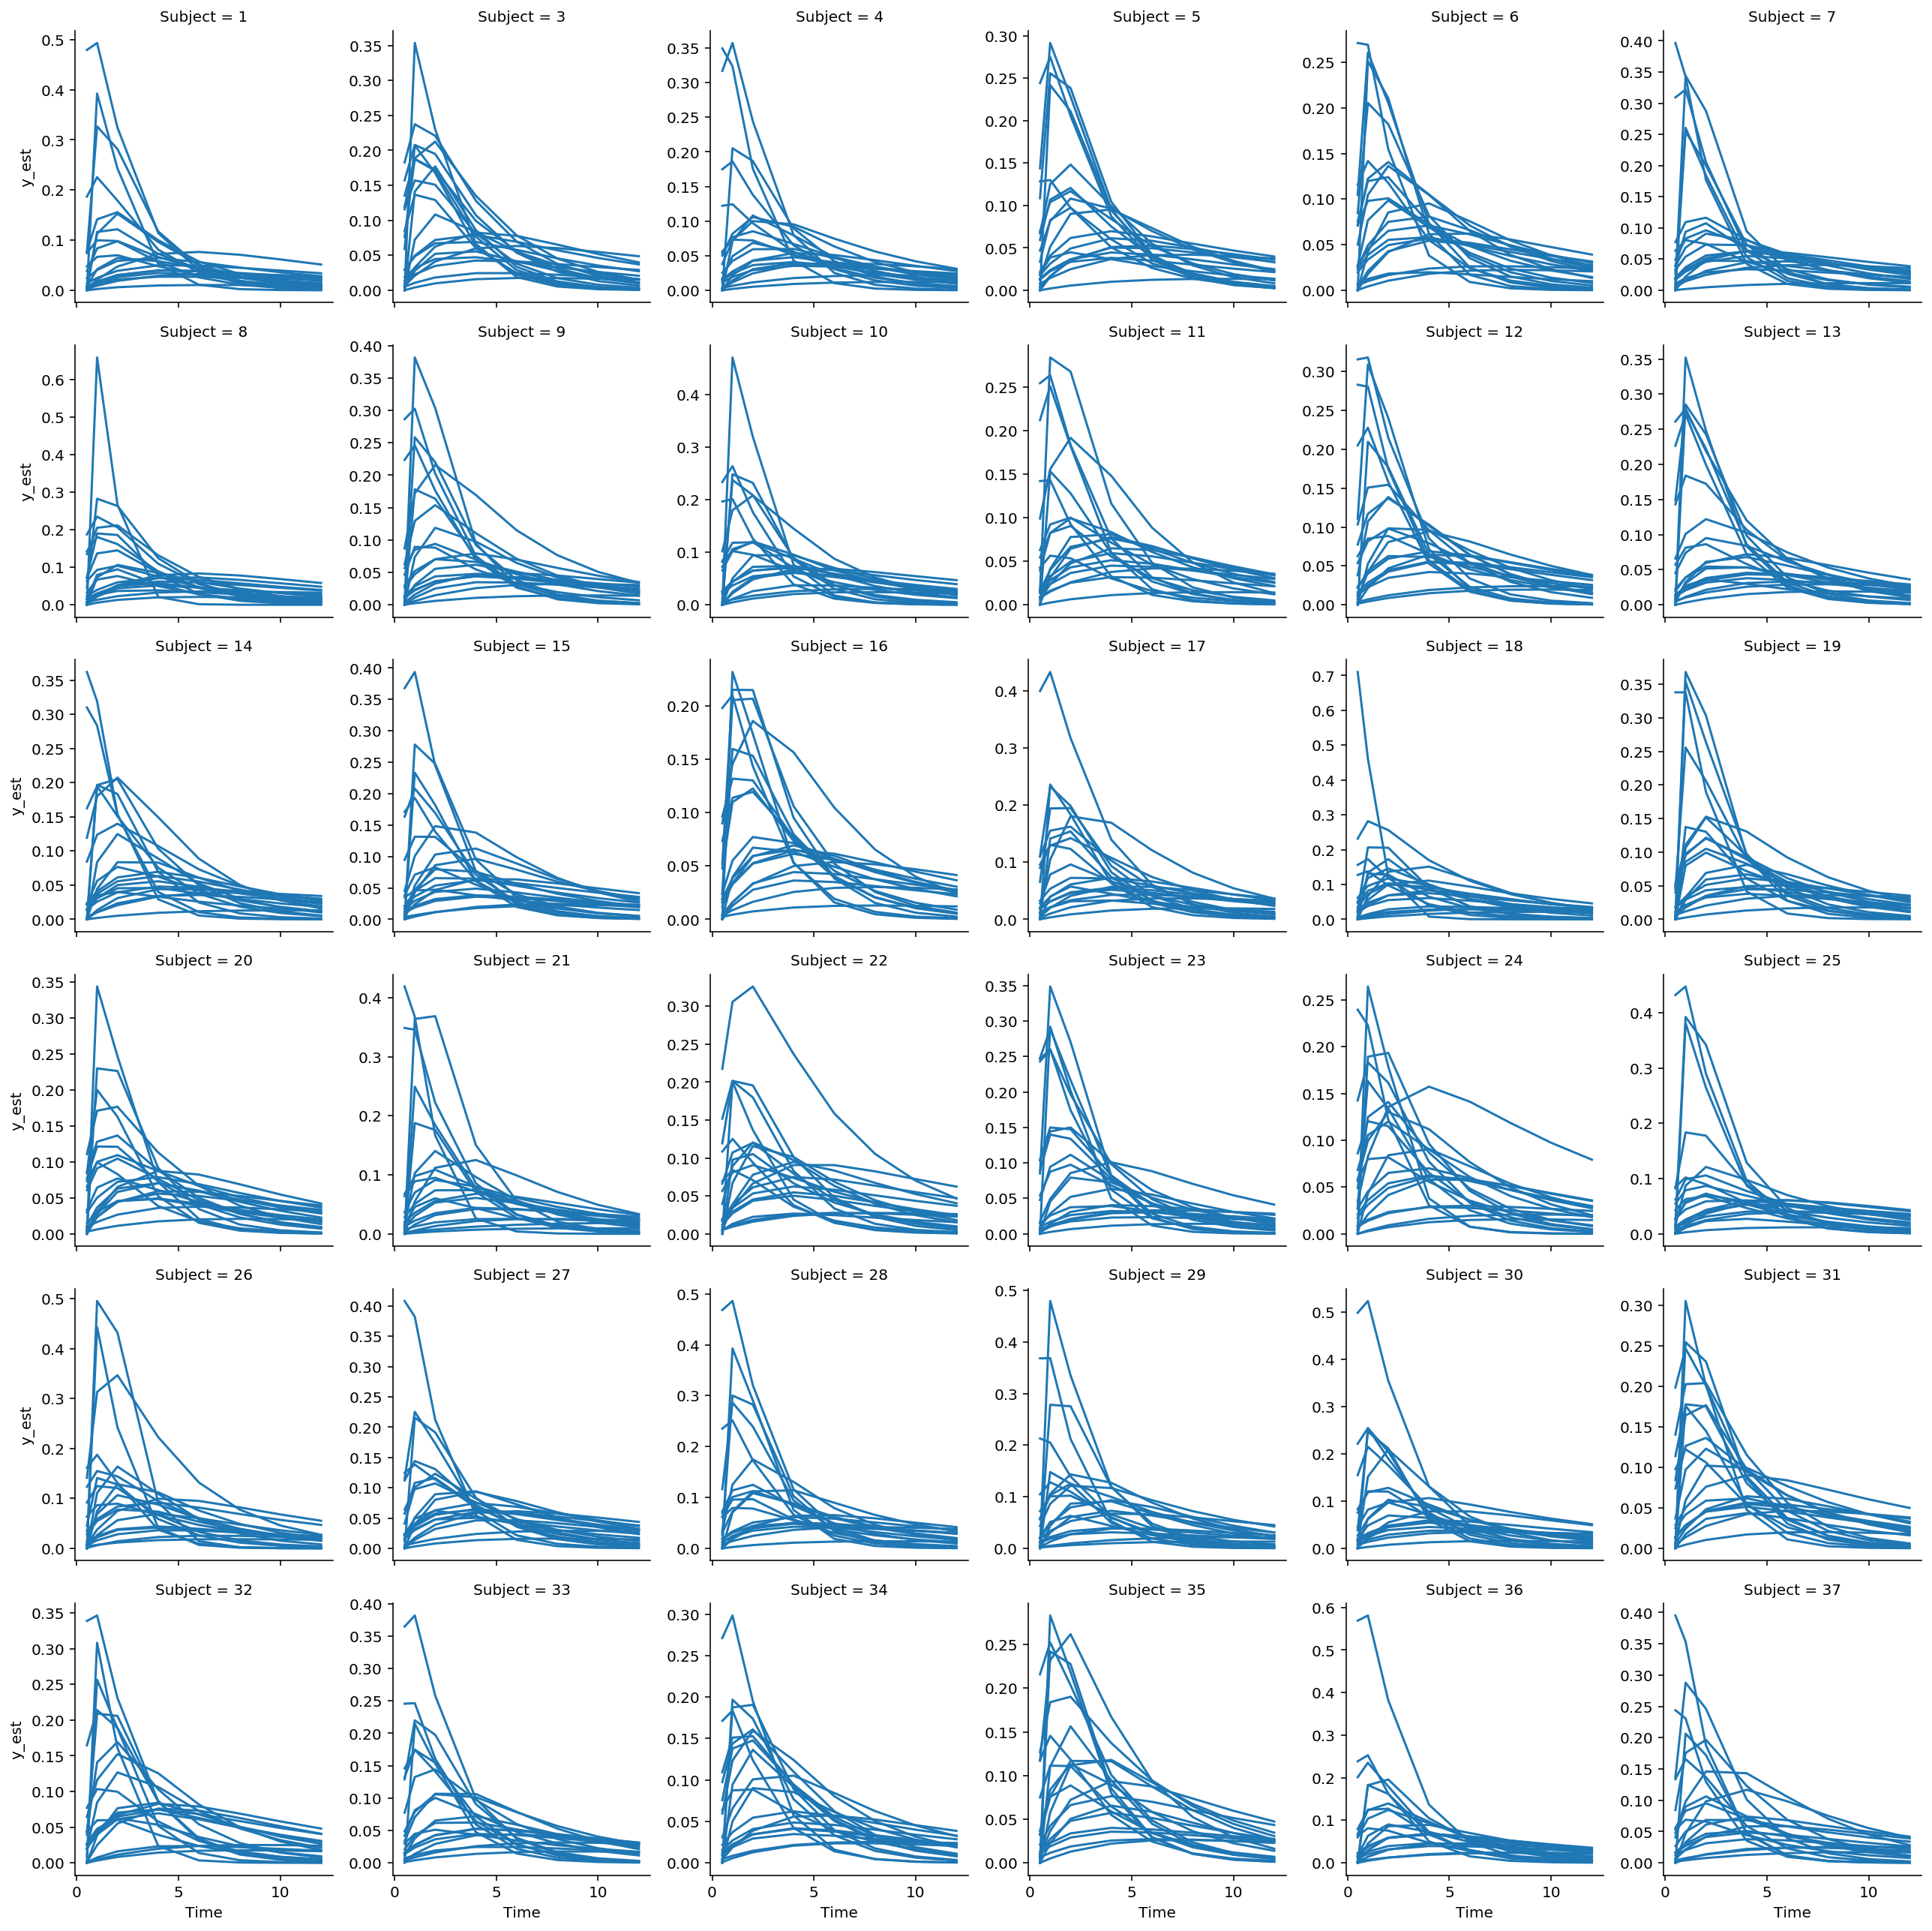

In [13]:
model_prior = model.prior.y_est.to_dataframe().query('draw<20')
dfsub = model_data.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='y_est_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6, sharey = False)
g.map_dataframe(sns.lineplot,'Time','y_est',estimator=None, units='draw')

# Model Fit

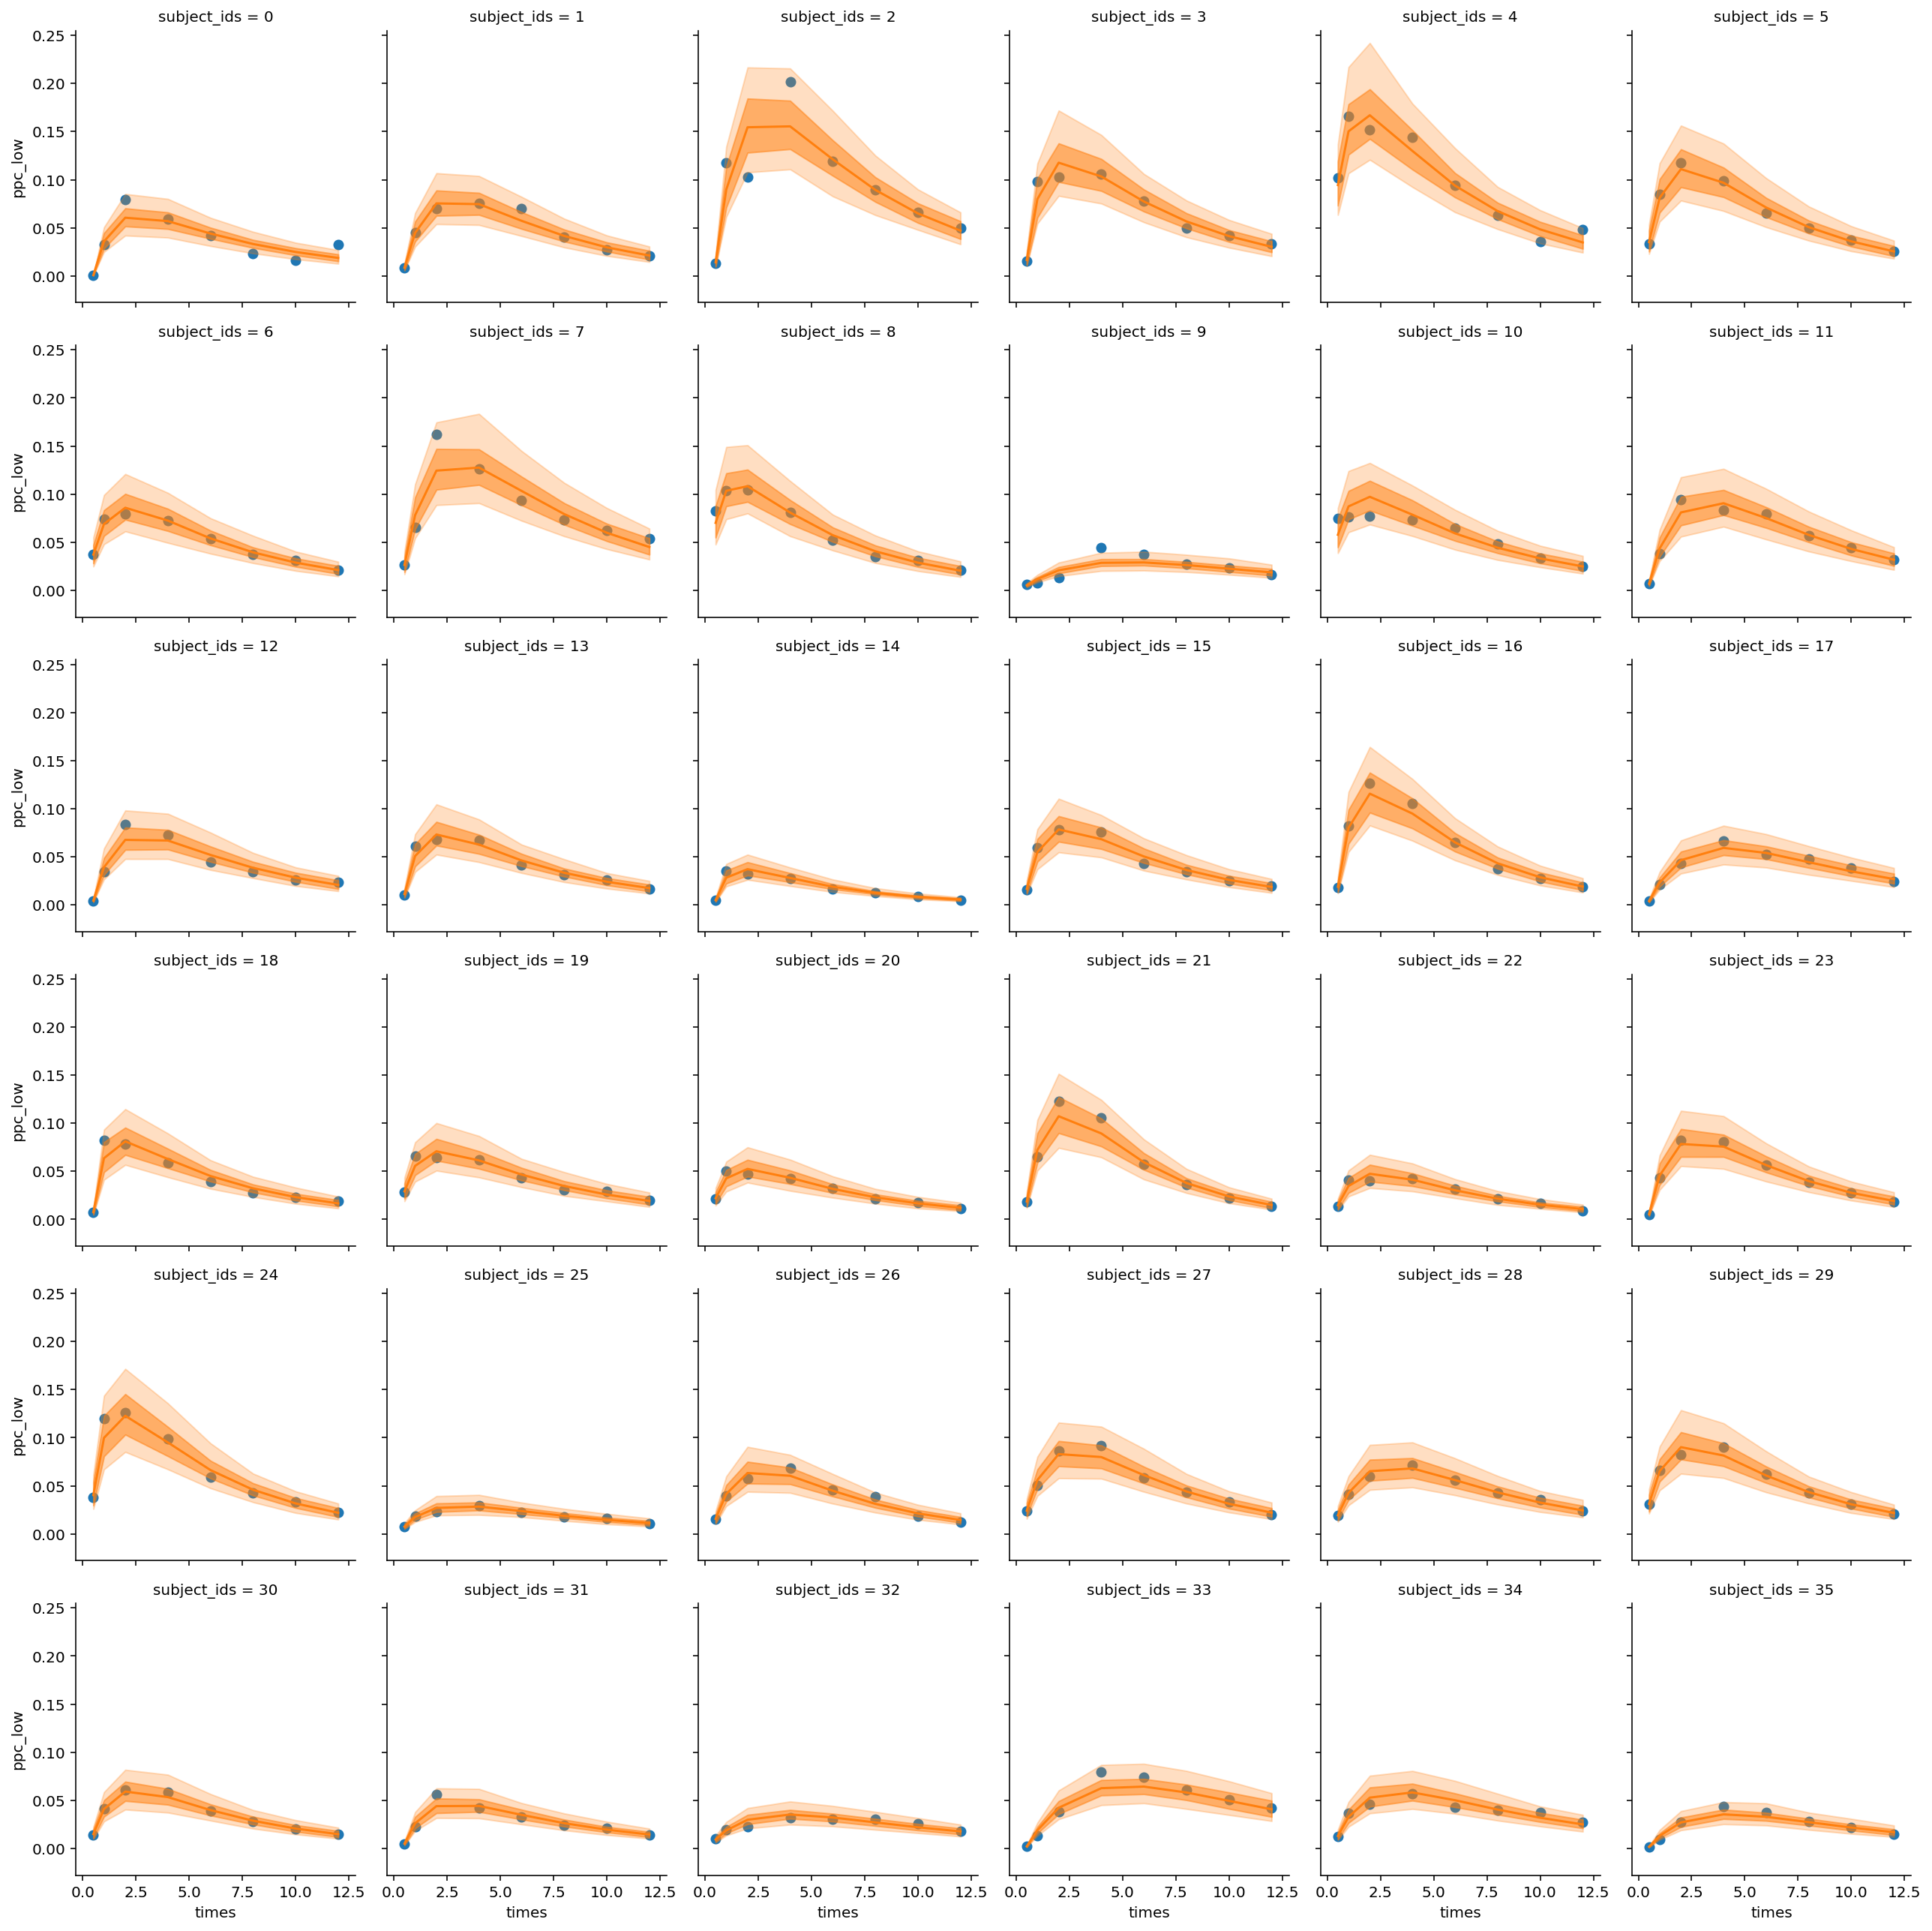

In [19]:
predictions = summarize_posterior(model.posterior, 'y_est', 'pred')
ppc = summarize_ppc(model.posterior_predictive,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred, col='subject_ids', col_wrap=6, sharey = True)
g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

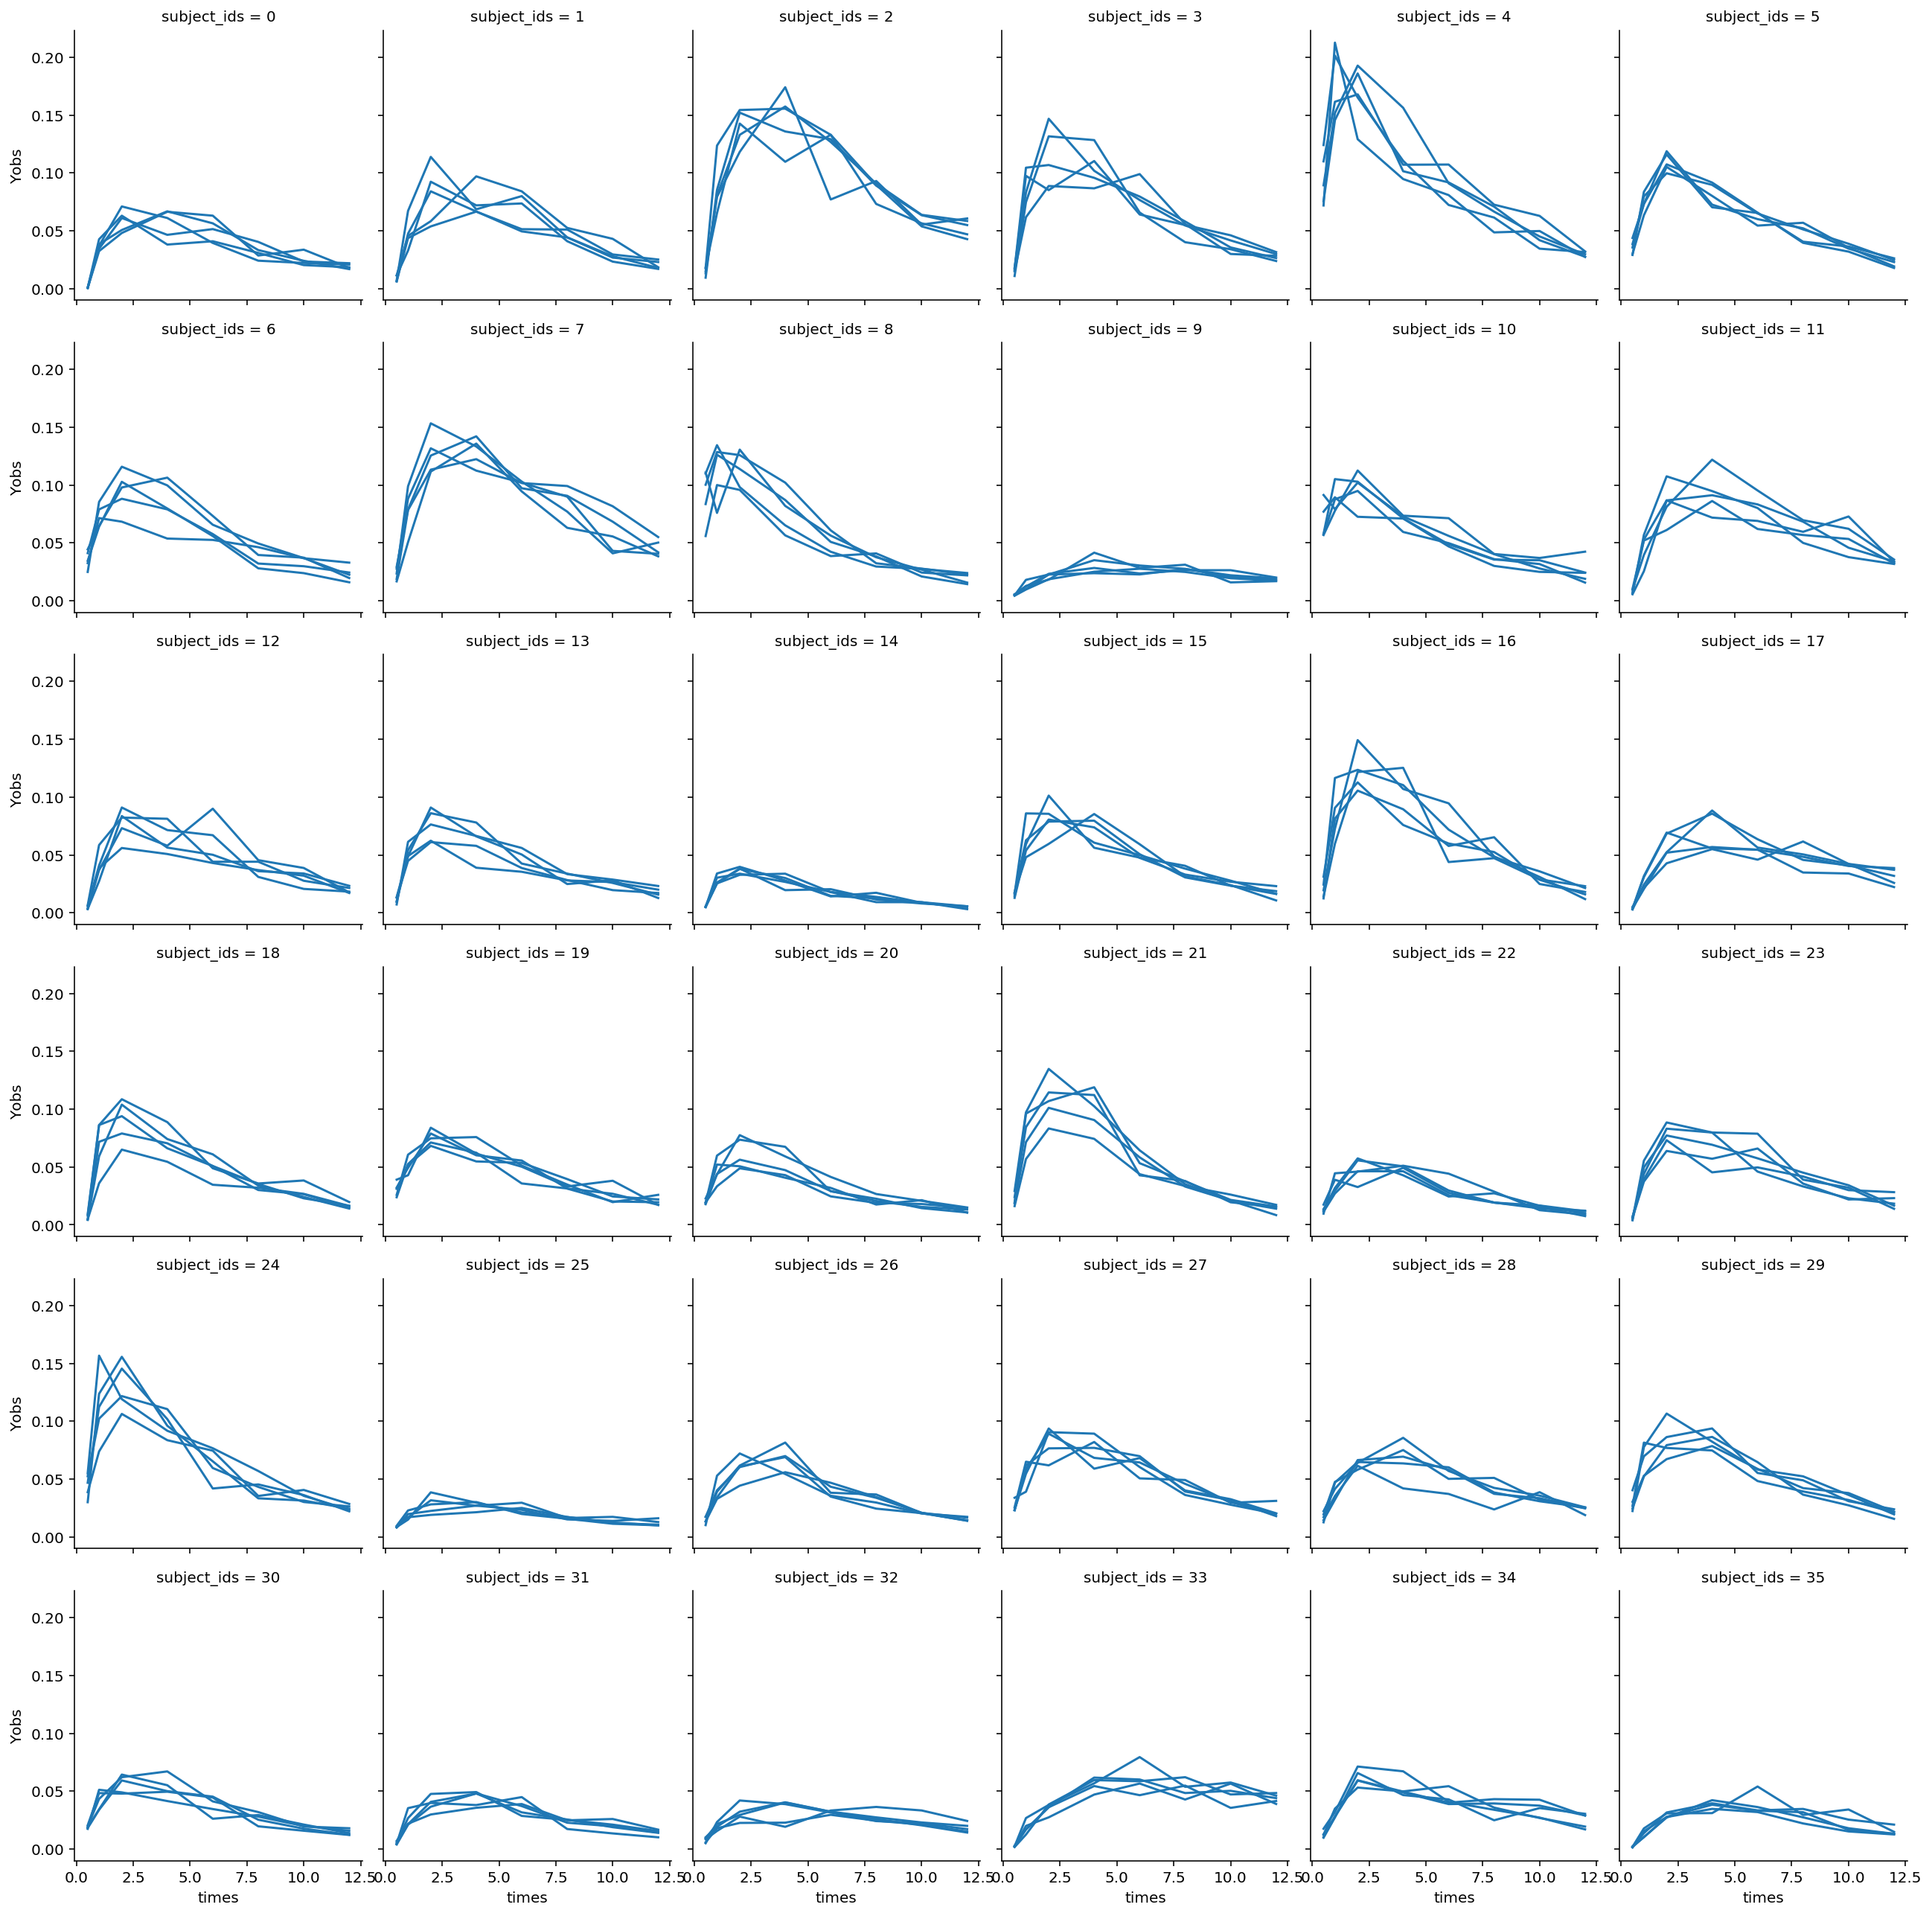

In [24]:
model_prior = model.posterior_predictive.Yobs.to_dataframe().query('draw<5 and chain==1')
dfsub = df.loc[:,['times','subject_ids']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='Yobs_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='subject_ids', col_wrap=6, sharey = True)
g.map_dataframe(sns.lineplot,'times','Yobs',estimator=None, units='draw')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c49121f50>,
      dtype=object)

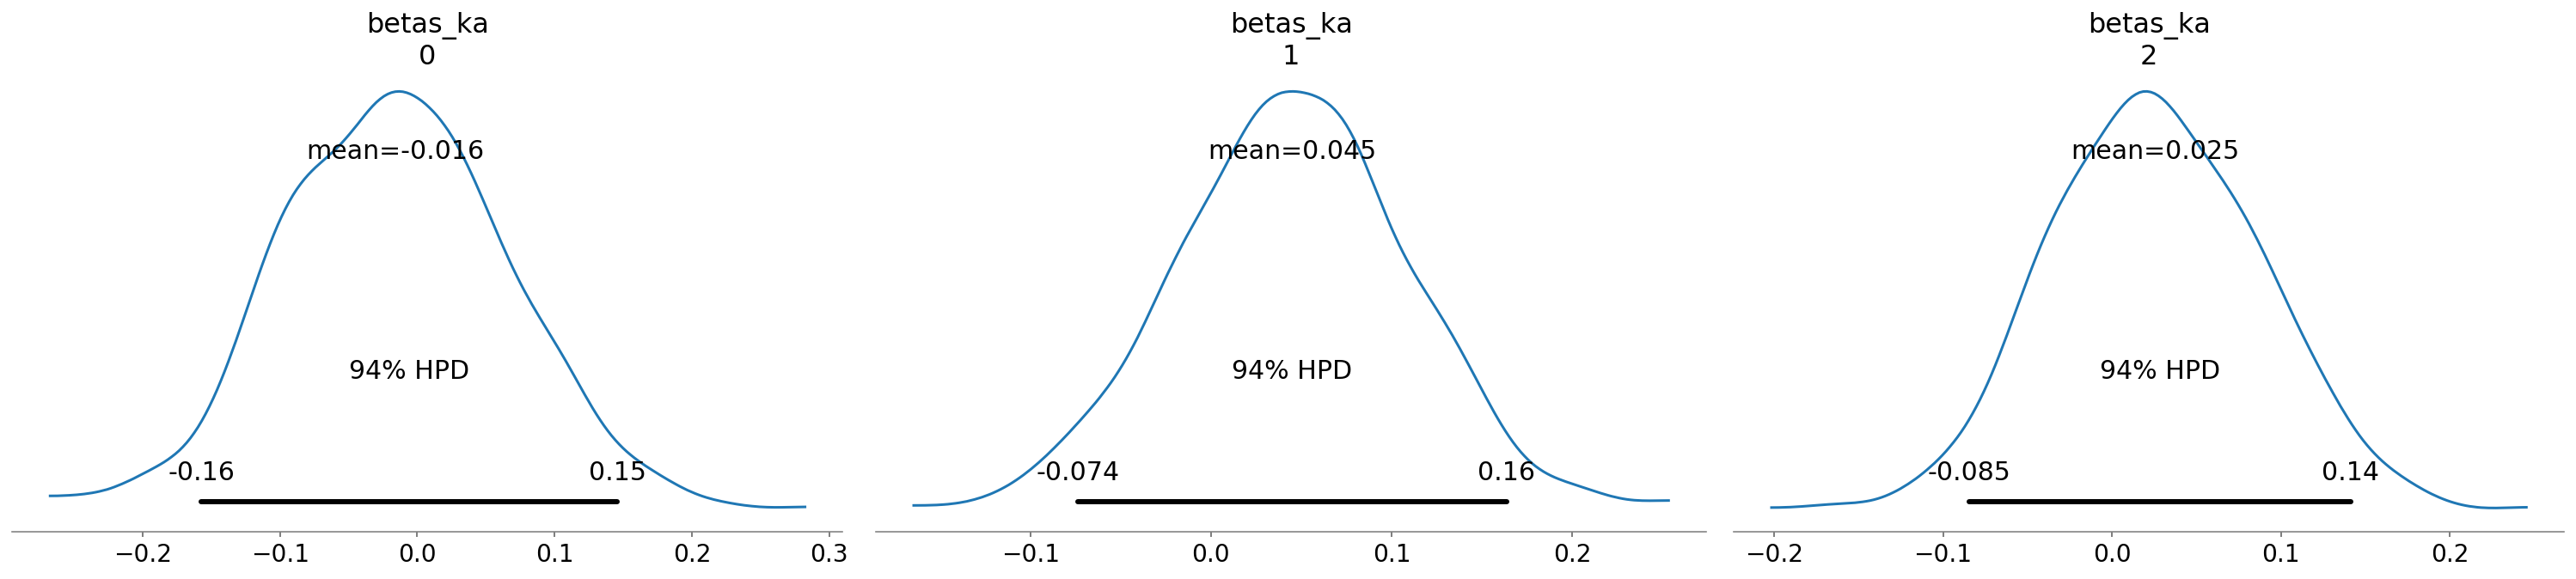

In [119]:
az.plot_posterior(model, var_names=['betas_ka'])

In [123]:
model.posterior.betas_ka.to_dataframe().unstack(level=2).std()

          betas_ka_dim_0
betas_ka  0                 0.082175
          1                 0.064104
          2                 0.061901
dtype: float64

In [129]:
np.corrcoef(X.T).round(2)

array([[ 1.  , -0.05,  0.12],
       [-0.05,  1.  , -0.01],
       [ 0.12, -0.01,  1.  ]])